<a href="https://colab.research.google.com/github/HebaRouk/AWS-PROJECT-2--of-Developing-a-Handwritten-Digits-Classifier-with-PyTorch---Heba-Rouk-2222222.ipynb/blob/main/AWS_PROJECT_2_of_Developing_a_Handwritten_Digits_Classifier_with_PyTorch_Heba_Rouk_2222222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.6 * len(mnist_dataset))  # 60% for training
val_size = int(0.2 * len(mnist_dataset))    # 20% for validation
test_size = len(mnist_dataset) - train_size - val_size  # Remaining for test (20%)

# Splitting the MNIST dataset

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.05MB/s]


In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


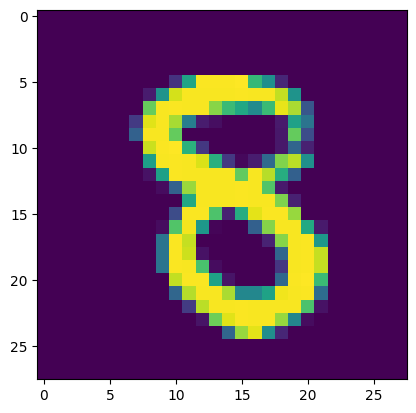

1


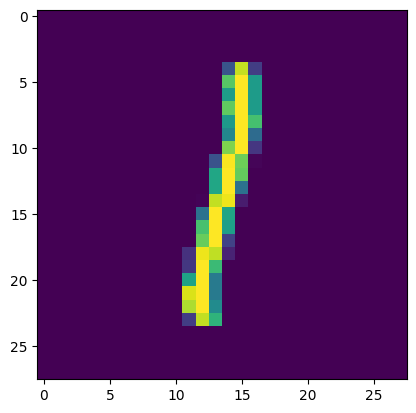

3


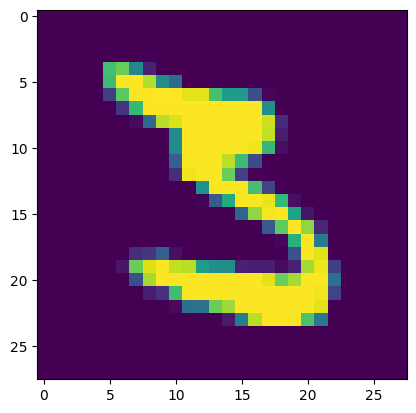

5


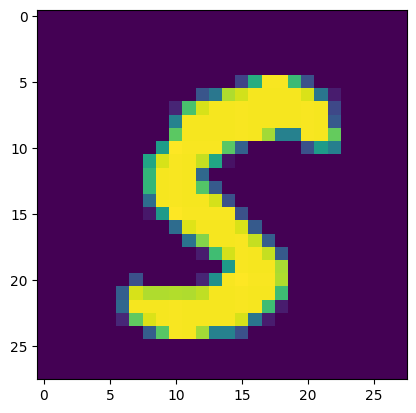

2


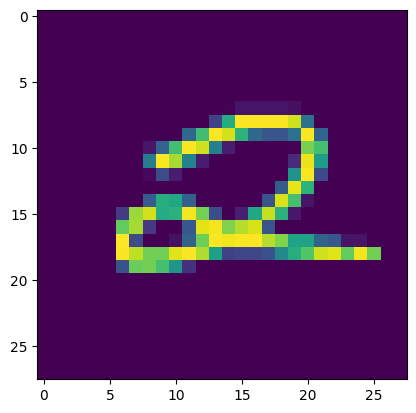

In [5]:
# Explore data
show5(train_loader)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))

    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 34.11% training loss: 2.12082
Epoch 1 validation accuracy: 61.56% validation loss: 1.84475
Epoch 2 training accuracy: 61.59% training loss: 1.84407
Epoch 2 validation accuracy: 65.41% validation loss: 1.80599
Epoch 3 training accuracy: 64.93% training loss: 1.81065
Epoch 3 validation accuracy: 65.46% validation loss: 1.80509
Epoch 4 training accuracy: 67.12% training loss: 1.78714
Epoch 4 validation accuracy: 71.33% validation loss: 1.74285
Epoch 5 training accuracy: 82.30% training loss: 1.64045
Epoch 5 validation accuracy: 88.33% validation loss: 1.57940
Epoch 6 training accuracy: 88.32% training loss: 1.57930
Epoch 6 validation accuracy: 90.34% validation loss: 1.55988
Epoch 7 training accuracy: 89.81% training loss: 1.56512
Epoch 7 validation accuracy: 90.81% validation loss: 1.55547
Epoch 8 training accuracy: 90.78% training loss: 1.55731
Epoch 8 validation accuracy: 89.48% validation loss: 1.56786
Epoch 9 training accuracy: 92.20% training loss: 1.54196

Plot the training loss (and validation loss/accuracy, if recorded).

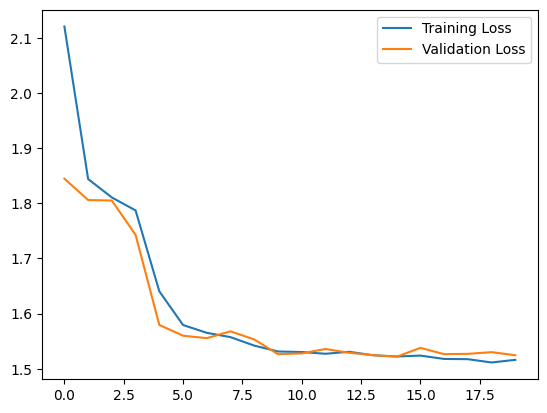

In [10]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [11]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.42%


In [12]:
# exprimenting with the optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [ ]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.64%


In [15]:
torch.save(net.state_dict(), "saved_model.pth")

In [16]:
# Assuming your model class is called Net
net = Net()

# Load the saved model
model_path = "saved_model.pth"
checkpoint = torch.load(model_path)

# Check if the 'model_state_dict' key is present in the checkpoint
if 'model_state_dict' in checkpoint:
    # Load the model's state_dict
    net.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully.")
else:
    # If the key is not present, try loading the entire state dictionary
    net.load_state_dict(checkpoint)
    print("Model loaded successfully (full state dictionary).")

# If you also saved optimizer state, you can load it as well
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If you saved other information such as training epochs or loss history, you can load them too
# For example, if you saved the number of epochs
if 'epoch' in checkpoint:
    epoch = checkpoint['epoch']

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()


Model loaded successfully (full state dictionary).


Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

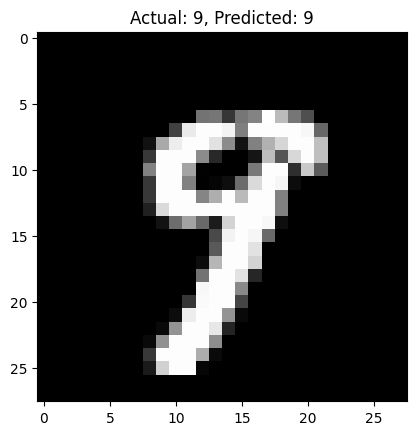

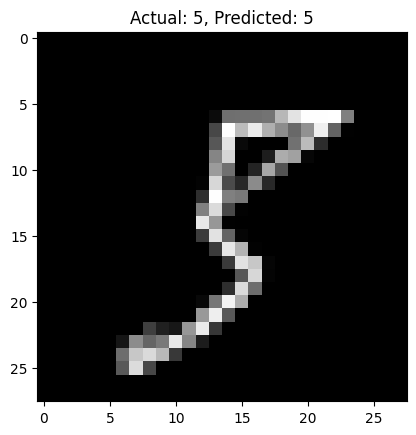

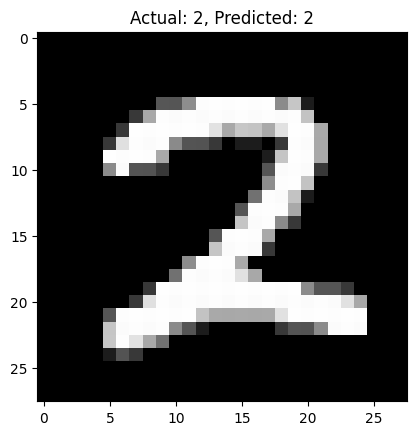

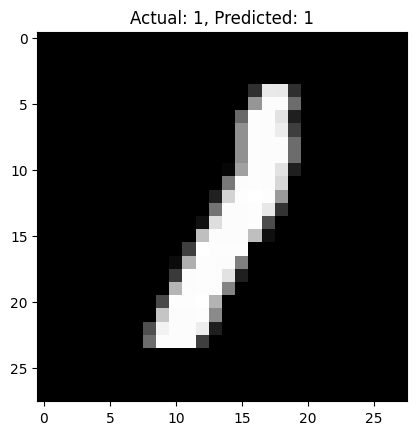

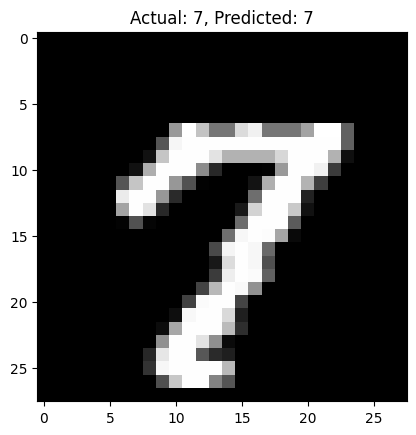

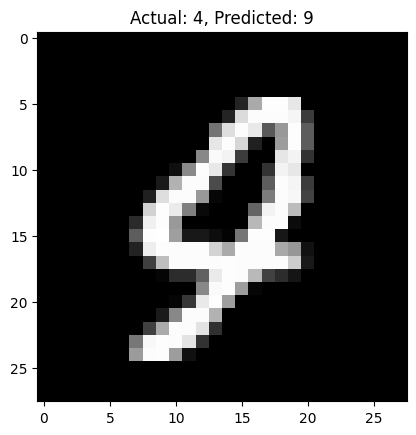

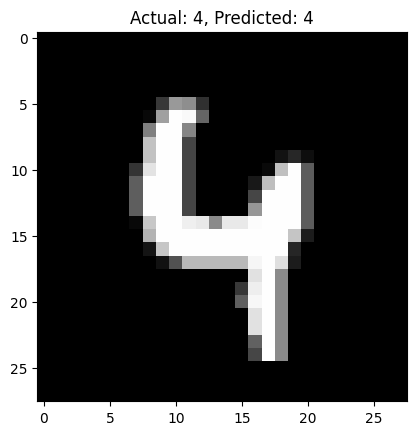

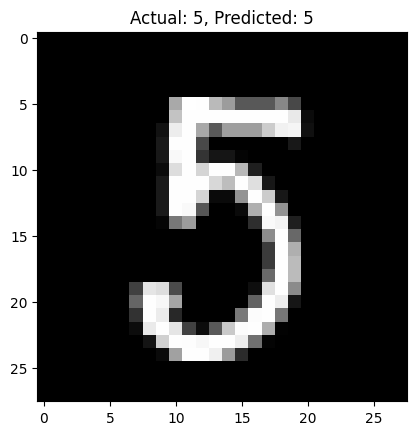

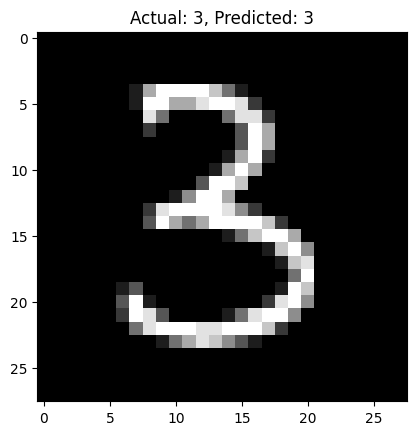

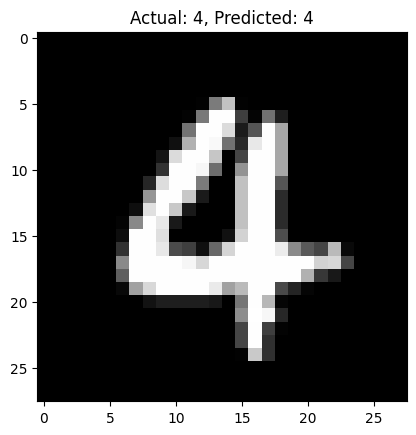

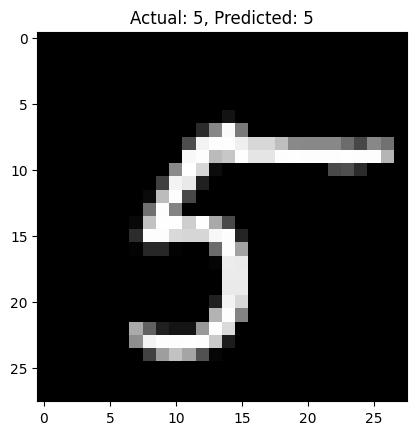

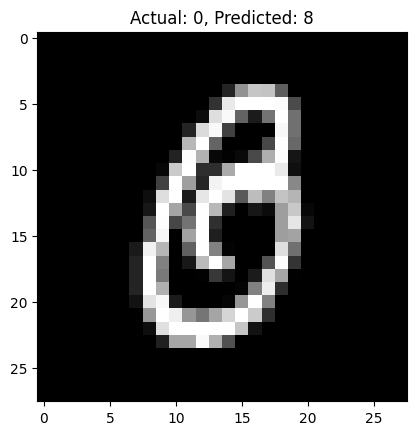

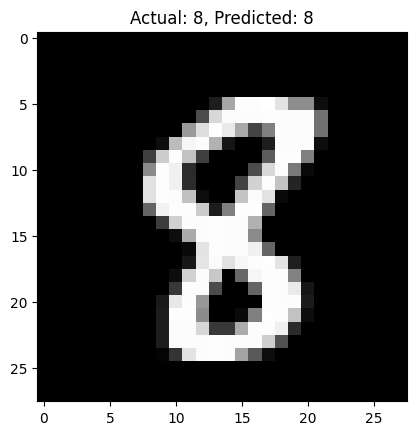

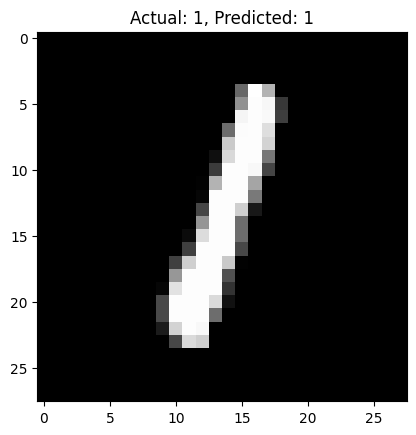

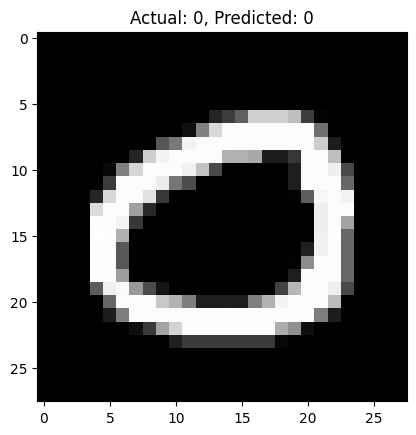

In [17]:
def visualize_results(model, dataloader, device):
    model.eval()

    # Get the total number of samples in the dataset
    total_samples = len(dataloader.dataset)

    # Randomly select 15 indices
    random_indices = random.sample(range(total_samples), 15)

    with torch.no_grad():
        for idx in random_indices:
            inputs, labels = dataloader.dataset[idx]
            inputs, labels = inputs.unsqueeze(0).to(device), torch.tensor([labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy arrays
            inputs = inputs.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            # Display the sample
            plt.imshow(np.squeeze(inputs), cmap='gray')
            plt.title(f"Actual: {labels.item()}, Predicted: {preds[0]}")
            plt.show()

# Call the function with the model and the test dataloader
visualize_results(net, test_loader, device)

## Confusion matrix

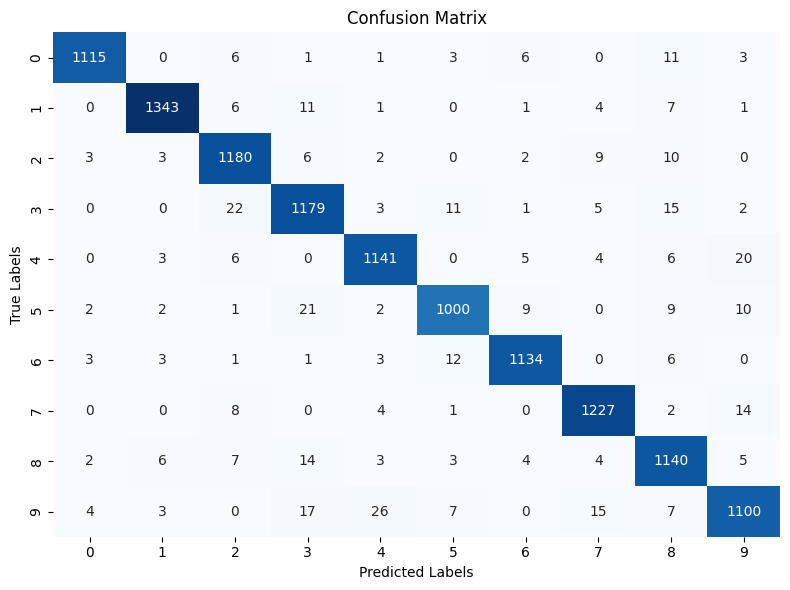

In [18]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure evaluation mode
net.eval()

# Initialize counters and storage
correct_predictions = 0
total_predictions = 0
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        total_predictions += labels.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
